# Collaboration and Competition

---

Implement multi-agent DDPG for the tennis environment using the Unity ML-Agents toolkit. 

The program has 3 parts :
- Part 1 Defines the classes, initiates the environment and so forth. It sets up all the scaffolding needed
- Part 2 Explore and Learn - it performs the DDPG Reinforcement Learning. It also saves the best model
- Part 3 Run saved model
- I have captured portion of the runs in the files `Before_RL-01.m4v`, `After_RL_Slow-01.m4v` and `After_RL_Fast-01.m4v`. So one can run the mp4 file to see how the agent behaves.

So one can either :
- Run the cells in Part 1 and then Part 2 -> to train a model, explore hyperparameters and so forth (slow)
- `Or` 
- Run cells in Part 1 and then Part 3 -> to run a stored model (fast)
- `Or`
- Watch the three videos viz. `Before_RL-01.m4v`, `After_RL_Slow-01.m4v` and `After_RL_Fast-01.m4v` (fastest)

## Part 1 - Definitions & Setup

### 1.1. Install the required packages

The required setup is detailed in the README.md

I am running this on a MacBookPro 14,3 

### 1.2. Define imports

python 3, numpy, matplotlib, torch

In [1]:
# General imports
import numpy as np
import random
from collections import namedtuple, deque
import copy

import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Constants Definitions
BUFFER_SIZE = int(1e5) # int(1e6) # int(1e5)  # replay buffer size  ?
BATCH_SIZE = 64 # 128 # 64 # 256        # minibatch size for training
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 5e-4 # 1e-3 # 1e-4 # 5e-4 # 1e-4 # 0.001 # 1e-4         # learning rate of the actor 
LR_CRITIC = 6e-4 # 3e-3 # 3e-4  # 6e-4 # 3e-4  # 3e-3 # 0.001 # 3e-4        # learning rate of the critic 0.001
WEIGHT_DECAY = 0.0001   # L2 weight decay
# Number of neurons in the layers of the Actor & Critic Networks
FC_UNITS_ACTOR = [32,32] # [16,16] # [8,8] # [64,64] # [32,16] # [128,128] # [64,128] # [32,16] # [400,300] # [128,128]
FC_UNITS_CRITIC = [32,32] # [16,16] # [8,8] # [64,64] # [32,16] # [128,128] # [64,128] # [32,16] # [400,300] # [128,128]
# Store models flag. Store during calibration runs and do not store during hyperparameter search
# Used in Part 3 to run a stored model
STORE_MODELS = True # False # True - Turn it on when you are ready to do the calibration training 

The unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

`Note : The file_name might be different for different OS. As mentioned earlier, I am running OSX on a MAcBookPro`

In [3]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name='Tennis.app') #'Reacher_20.app')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 1.3. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

- The cell below tests to make sure the environment is up and running by printing some information about the environment.
- It also acquires the dimensions of the state and action space

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


The unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

`Note : The file_name might be different for different OS. As mentioned earlier, I am running OSX on a MAcBookPro`

### 1.4. Define classes and setup

The device declaration enables the program leverage GPUs if they are available

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device = {}'.format(device))

Device = cpu


### 1.5. Learning Algorithm

We are using the multi-agent DDPG as explained in the report.
<img src="RL_Systems_Flow.png" style="float:left">

The major components of the algorithm are:
1. `Actor` implemented as a Deep Neural Network whih consists of fully connected layers.
2. `Critic` implemented as a Deep Neural Network which consists of fully connected networks
3. `Experience replay buffer` - in order to train the network we take actions and then store the results in the replay buffer. The replay buffer is a circular buffer and it has methods to sample a random batch
3. `The Agent` brings all of the above together. It interacts with the environment by taking actions based on a policy, collects rewards and the observation feedback, then stores the experience in the replay buffer and also initiates a learning step on the actor and critic networks. The accompanying Report.pdf has more details on the agent and how multi-agent paradigms are implemented.

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
# Finally used Xavier Initialization, which is very similar

In [7]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size=state_size, action_size=action_size, seed=42, fc_units=FC_UNITS_ACTOR):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state, defaults to the global state size from the env
            action_size (int): Dimension of each action, defaults to the global action size from the env
            seed (int): Random seed
            fc_units (list(int)): Number of nodes in the hidden layers as a list
            ** Hard coded as a 3 layer network 
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.model = nn.Sequential(
            #nn.BatchNorm1d(state_size),
            nn.Linear(state_size,fc_units[0]),
            nn.ReLU(),
            #nn.BatchNorm1d(fc_units[0]),
            nn.Linear(fc_units[0],fc_units[1]),
            nn.ReLU(),
            #nn.BatchNorm1d(fc_units[1]),
            nn.Linear(fc_units[1],action_size),
            nn.Tanh()
        )
        self.model.apply(self.init_weights)

    def init_weights(self,m):
        if (type(m) == nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            #nn.init.xavier_normal_(m.weight)
            # nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(1.0)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        return self.model(state)

In [8]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size = state_size, action_size = action_size, seed=42, fc_units=FC_UNITS_CRITIC):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state, defaults to the global state size from the env
            action_size (int): Dimension of each action, defaults to the global action size from the env
            seed (int): Random seed
            fc_units (list(int)): Number of nodes in the hidden layers as a list
            ** Hard coded as a 3 layer network 
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.hc_1 = nn.Sequential(
            nn.Linear(state_size,fc_units[0]),
            nn.ReLU(), # leaky relu ?
            nn.BatchNorm1d(fc_units[0])
        )
        self.hc_2 = nn.Sequential(
            nn.Linear(fc_units[0]+action_size,fc_units[1]),
            nn.ReLU(), # leaky relu ?
            nn.Linear(fc_units[1],1)
        )
        # Initialize the layers
        self.hc_1.apply(self.init_weights)
        self.hc_2.apply(self.init_weights)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = self.hc_1(state)
        x = torch.cat((xs, action), dim=1)
        x = self.hc_2(x)
        return (x)
    
    def init_weights(self,layer):
        if (type(layer) == nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(1.0)


In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed=42):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=False): #True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


# 1.6. Instantiate the shared agent instance

The state space and the action space dimensions come from the environment

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)
print(agent.actor_local)
print(agent.critic_local)

Actor(
  (model): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Tanh()
  )
)
Critic(
  (hc_1): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hc_2): Sequential(
    (0): Linear(in_features=34, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


## Part 2 - Learn & Train
-----
#### _**Note : If you want to run a stored model, skip Part 2 and run the cells in Part 3 below after the run logs & test area**_

### 2.1. Multi-agent DDPG Algorithm

Define the DDPG Algorithm. Once we have defined the foundations (network, buffer, actor, critic, agent and so forth), the DDPG is relatively easy. It has a few responsibilities:
1. Orchastrate the episodes calling the appropriate methods
2. Manage the observations and actions for the two agents
2. Display a running commentry of the scores, percentile statistics and episode count
3. Check the success criterion for solving the environment i.e. if running average is > 0.5 and print the episode count
4. Store the model with the maximum score
5. Keep track of the scores for analytics at the end of the run

In [15]:
def ma_ddpg(n_episodes=2000, max_t=700):
    scores_window = deque(maxlen=100)
    steps_window = deque(maxlen=100)
    scores = []
    score  = 0
    max_score = -np.Inf
    solved = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                 # get the current state (for each agent)
        agent.reset()
        score = 0
        max_steps = 0
        for t in range(max_t):
            # print(state)
            actions=[]
            for a in range(num_agents):
                action = agent.act(states[a])
                actions.append(action)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            for a in range(num_agents):
                agent.step(states[a], actions[a], rewards[a], next_states[a], dones[a])
            states = next_states                               # roll over states to next time step
            score += np.max(rewards)
            if any(dones):
                break 
            max_steps += 1
        scores_window.append(score)
        steps_window.append(max_steps)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}\tMax_steps : {:4d}\tSteps Avg : {:6.3f}'.\
              format(i_episode, np.mean(scores_window), score, np.max(steps_window),np.mean(steps_window)), end="")
        if i_episode % 500 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore Stats: {}\tSteps Stats : {}'.\
                  format(i_episode, np.mean(scores_window), np.percentile(scores_window,[25,50,75,100]),\
                         np.percentile(steps_window,[25,50,75,100])))  
        if (np.mean(scores_window) >= 0.5) and (not solved):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:5.2f}'.\
                  format(i_episode, np.mean(scores_window)))
            # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            solved = True
            # break
            # To see how far it can go
        # Store the best model if desired
        if STORE_MODELS:
            if np.mean(scores_window) > max_score:
                max_score = np.mean(scores_window)
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                # print(' .. Storing with score {}'.format(max_score))
    return scores

### 2.2. The actual training Run

1. Run the Multi-Agent DDPG
2. Calculate and display end-of-run analytics viz. descriptive statistics and a plot of the scores

Episode 500	Average Score: 0.00	Score Stats: [0. 0. 0. 0.]	Steps Stats : [13. 13. 13. 14.]
Episode 1000	Average Score: 0.00	Score Stats: [0. 0. 0. 0.]	Steps Stats : [13. 13. 13. 14.]
Episode 1500	Average Score: 0.06	Score Stats: [0.         0.         0.1        0.50000001]	Steps Stats : [ 13.  16.  33. 112.]
Episode 2000	Average Score: 0.00	Score Stats: [0.  0.  0.  0.1]	Steps Stats : [13. 13. 13. 31.]
Episode 2500	Average Score: 0.03	Score Stats: [0.  0.  0.1 0.1]	Steps Stats : [16. 16. 32. 33.]
Episode 3000	Average Score: 0.06	Score Stats: [0.         0.         0.1        0.60000001]	Steps Stats : [ 15.  17.  32. 128.]
Episode 3500	Average Score: 0.06	Score Stats: [0.         0.         0.1        0.50000001]	Steps Stats : [ 13.   14.5  32.  111. ]
Episode 4000	Average Score: 0.15	Score Stats: [0.         0.1        0.2        0.90000001]	Steps Stats : [ 15.75  32.    51.25 186.  ]
Episode 4500	Average Score: 0.17	Score Stats: [0.1        0.1        0.2        0.60000001]	Steps Sta

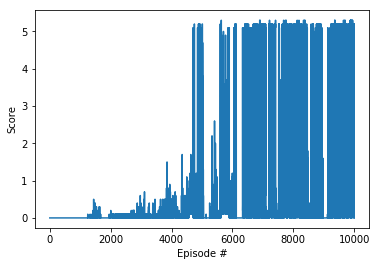

Actor(
  (model): Sequential(
    (0): Linear(in_features=24, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Tanh()
  )
)
Max Score 5.300000 at 5634
Percentile [25,50,75] : [0.  0.1 0.3]
Variance : 2.949


In [14]:
start_time = time.time()
scores = ma_ddpg(n_episodes=10000,max_t=1000) # 2000,1500 or 1500,1500 ; quick test 100,500
# The env ends at 1000 steps. Tried max_t > 1K. Didn't see any complex adaptive temporal behavior
env.close() # Close the environment
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
print(agent.actor_local)
# print(agent.critic_local)
print('Max Score {:2f} at {}'.format(np.max(scores), np.argmax(scores)))
print('Percentile [25,50,75] : {}'.format(np.percentile(scores,[25,50,75])))
print('Variance : {:.3f}'.format(np.var(scores)))

### 2.3. Run logs & Notes

1. A place to keep the statistics and qualitative observations
2. It is easier to keep notes as soon as a run is done
3. Also a place to keep future explorations

In [ ]:
'''
Logs
[10/20/18] Initial try
100 episode - nothing happens
Trying 100000
FC32-FC16-FC4
** [10/20/18 6:40 PM] FC64-FC64-FC2
worse - nothing more than 0. Rackets collide !
** FC8-FC8-FC2
Episode 3300	Average Score: 0.07
Episode 3400	Average Score: 0.06
Episode 3500	Average Score: 0.08
Episode 3600	Average Score: 0.06
Episode 3700	Average Score: 0.06
Episode 3800	Average Score: 0.05
Episode 3900	Average Score: 0.05
Episode 3961	Average Score: 0.02
not good
** lr to 1e-4
no learning after ~1000 that too was at 0.01 et al.
** lr to 0.001 - not learning anythong. Rackets hit each other
** FC16-FC16-FC2 lr 5e-4 3e-4
Getting better by ~4500. even went upto 500 steps !
Solved in 5400 steps. if max_t was higher it would have gone more !
But goes down after that !
2.6 at steps 500
0.5 ~ 190 steps
stop at 500 because don't want to spike, may be later.
Episode 6300	Average Score: 0.39
Episode 6400	Average Score: 0.56
Episode 6500	Average Score: 0.58
Episode 6600	Average Score: 0.44
Episode 6700	Average Score: 0.76
Episode 6800	Average Score: 1.04
Episode 6900	Average Score: 0.37
Episode 7000	Average Score: 1.33
Episode 7095	Average Score: 0.25	Score: 1.2000000178813934	Max_steps : 228
Not consistent at ~7000, > 100000 episodes ?
Episode 7900	Average Score: 1.45
Episode 7908	Average Score: 1.50	Score: 2.500000037252903	Max_steps : 500
Larger Network ?
Episode 8400	Average Score: 0.97
Episode 8500	Average Score: 1.09
Episode 8600	Average Score: 0.31
Episode 8700	Average Score: 0.25
Episode 8800	Average Score: 0.43
Episode 8900	Average Score: 0.28
Episode 9000	Average Score: 0.34
Episode 9100	Average Score: 0.26
Episode 9200	Average Score: 0.33
Episode 9300	Average Score: 0.86
Episode 9400	Average Score: 0.43
Episode 9500	Average Score: 0.18
Episode 9600	Average Score: 0.23
Episode 9700	Average Score: 0.19
Episode 9800	Average Score: 0.21
Episode 9900	Average Score: 0.26
Episode 10000	Average Score: 0.22
Elapsed : 1:50:51.814972
2018-10-20 21:06:46.727933
** max_t = 1000, FC32-FC32-FC2
printing step and score stats every 500
with max_t = 1000, larger scores, also the replay buffer is full of good actions
10/20 10:13 PM - This is going to be a 4 hr run ! took 6 hrs. But done well.
Episode 500	Average Score: 0.00	Score Stats: [0. 0. 0. 0.]	Steps Stats : [13. 13. 13. 14.]
Episode 1000	Average Score: 0.00	Score Stats: [0. 0. 0. 0.]	Steps Stats : [13. 13. 13. 14.]
Episode 1500	Average Score: 0.06	Score Stats: [0.         0.         0.1        0.50000001]	Steps Stats : [ 13.  16.  33. 112.]
Episode 2000	Average Score: 0.00	Score Stats: [0.  0.  0.  0.1]	Steps Stats : [13. 13. 13. 31.]
Episode 2500	Average Score: 0.03	Score Stats: [0.  0.  0.1 0.1]	Steps Stats : [16. 16. 32. 33.]
Episode 3000	Average Score: 0.06	Score Stats: [0.         0.         0.1        0.60000001]	Steps Stats : [ 15.  17.  32. 128.]
Episode 3500	Average Score: 0.06	Score Stats: [0.         0.         0.1        0.50000001]	Steps Stats : [ 13.   14.5  32.  111. ]
Episode 4000	Average Score: 0.15	Score Stats: [0.         0.1        0.2        0.90000001]	Steps Stats : [ 15.75  32.    51.25 186.  ]
Episode 4500	Average Score: 0.17	Score Stats: [0.1        0.1        0.2        0.60000001]	Steps Stats : [ 31.   45.   61.5 141. ]
Episode 4724	Average Score: 0.51	Score: 5.100	Max_steps : 1000	Steps Avg : 113.180
Environment solved in 4724 episodes!	Average Score:  0.51
Episode 5000	Average Score: 1.17	Score Stats: [0.         0.2        1.72500003 5.20000008]	Steps Stats : [  16.   51.  338. 1000.]
Episode 5500	Average Score: 0.30	Score Stats: [0.         0.2        0.40000001 2.60000004]	Steps Stats : [ 14.   53.   99.5 561. ]
Episode 6000	Average Score: 0.21	Score Stats: [0.         0.1        0.3        1.20000002]	Steps Stats : [ 13.75  45.5   82.5  303.  ]
Episode 6500	Average Score: 2.99	Score Stats: [0.3        4.00000006 5.10000008 5.20000008]	Steps Stats : [  75.   790.5 1000.  1000. ]
Episode 7000	Average Score: 2.76	Score Stats: [0.1        3.10000005 5.20000008 5.30000008]	Steps Stats : [  33.   596.5 1000.  1000. ]
Episode 7500	Average Score: 0.70	Score Stats: [0.         0.1        0.1        5.30000008]	Steps Stats : [  16.     31.     33.75 1000.  ]
Episode 8000	Average Score: 1.82	Score Stats: [0.1        0.35000001 5.10000008 5.20000008]	Steps Stats : [  32.   80. 1000. 1000.]
Episode 8500	Average Score: 1.95	Score Stats: [0.1        1.00000001 4.60000007 5.20000008]	Steps Stats : [  32.  210. 1000. 1000.]
Episode 9000	Average Score: 0.85	Score Stats: [0.         0.         0.25       5.20000008]	Steps Stats : [  13.   13.   64. 1000.]
Episode 9500	Average Score: 2.31	Score Stats: [0.2        1.15000002 5.10000008 5.20000008]	Steps Stats : [  52.   237.5 1000.  1000. ]
Episode 10000	Average Score: 2.72	Score Stats: [0.3        2.05000003 5.20000008 5.30000008]	Steps Stats : [  70.  406. 1000. 1000.]
Elapsed : 6:00:50.424233
2018-10-21 03:39:40.714783
env terminates at 1000
Questions:
1. Separate replay buffer ?
2.  
'''

### 2.4. Test Area

In [15]:
env.close()

## Part 3 : Run a stored Model

### Note
Here we are saving and loading the state dict, because we have access to the code.

Another way to save and load model, to be used by 2 distinct and separate entities is to :
- `torch.save(model, filepath)`; 
- Then later, `model = torch.load(filepath)`

In [13]:
# Load parameters from the saved file
# The file has the parameters of the model that has the highest score during training
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [14]:
start_time = time.time()
scores=[]
for i in range(50): # 10 episodes
    actions = np.zeros([num_agents, action_size])
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment train_mode = false is very slow
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    steps = 0                                          # Keep track of the number of steps
    while True:
        actions=[]
        for a in range(num_agents):
            action = agent.act(states[a])
            actions.append(action)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        states = next_states                               # roll over states to next time step
        score += np.max(rewards)# update the score
        if any(dones): # exit loop if episode finished
            break 
        else:
            steps += 1
    scores.append(score)
    print("Episode : {:2d} Score : {:5.2f} Steps : {}".format(i+1,score,steps))
# Print stats at the end the run
print('Mean of {} episodes = {}'.format(i+1,np.mean(scores)))
print('Elapsed : {}'.format(timedelta(seconds=time.time() - start_time)))
print(datetime.now())
env.close()

Episode :  1 Score :  1.00 Steps : 211
Episode :  2 Score :  1.00 Steps : 211
Episode :  3 Score :  2.00 Steps : 407
Episode :  4 Score :  3.60 Steps : 720
Episode :  5 Score :  0.60 Steps : 133
Episode :  6 Score :  4.40 Steps : 878
Episode :  7 Score :  1.00 Steps : 212
Episode :  8 Score :  5.10 Steps : 1000
Episode :  9 Score :  4.30 Steps : 855
Episode : 10 Score :  5.10 Steps : 1000
Episode : 11 Score :  2.90 Steps : 583
Episode : 12 Score :  5.10 Steps : 1000
Episode : 13 Score :  0.70 Steps : 152
Episode : 14 Score :  2.00 Steps : 406
Episode : 15 Score :  3.00 Steps : 603
Episode : 16 Score :  3.00 Steps : 603
Episode : 17 Score :  1.00 Steps : 208
Episode : 18 Score :  5.00 Steps : 1000
Episode : 19 Score :  0.40 Steps : 73
Episode : 20 Score :  2.00 Steps : 406
Episode : 21 Score :  2.00 Steps : 406
Episode : 22 Score :  4.40 Steps : 878
Episode : 23 Score :  1.40 Steps : 292
Episode : 24 Score :  5.00 Steps : 1000
Episode : 25 Score :  1.10 Steps : 230
Episode : 26 Score : 